In [17]:
from train import *
import matplotlib.pyplot as plt
import PIL.Image as Image
from utils import *
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1 - initial model

We used this [repository](https://github.com/Booritas/semantic-segmentation) as a base for our initial model. Initial model is not very good - we get the following results:

`Image File: 
File irudyak-7535.tif
Method description: 
First submission from my own keras model.
Submission Status: 
Scored
Rand Score Thin: 
0.837005210
Information Score Thin: 
0.943429268`

At least we have a room for improvements.

In [2]:
experiment_dir=Path('experiments/initial_model')
trainer = Trainer(experiment_dir=experiment_dir)

In [3]:
trainer.params.dict

{'learning_rate': 0.001,
 'input_shape': [512, 512, 1],
 'loss': 'binary_crossentropy',
 'steps_per_epoch': 100,
 'epochs': 25,
 'batch_size': 4,
 'start_epoch': 0,
 'last_step': 10,
 'padding': 'same',
 'batch_size_val': 1,
 'validation_steps': 3,
 'batch_size_test': 1}

In [4]:
!ls experiments/initial_model/

copy.sh
events.out.tfevents.1572186356.instance-2-gpu
params.json
test-volume-masks.tif
weights.10-0.91.hdf5
weights.30-0.91.hdf5


Let's try to predict mask on one of the validation images.

In [5]:
# image 25 was on validation set for initial model
img_arr = trainer.dataset.image_data[25]
mask_arr = trainer.dataset.mask_data[25] / 255.

In [6]:
weight_file = str(experiment_dir / 'weights.10-0.91.hdf5')
mask_pred = trainer.predict_image(img_arr, weight_file)

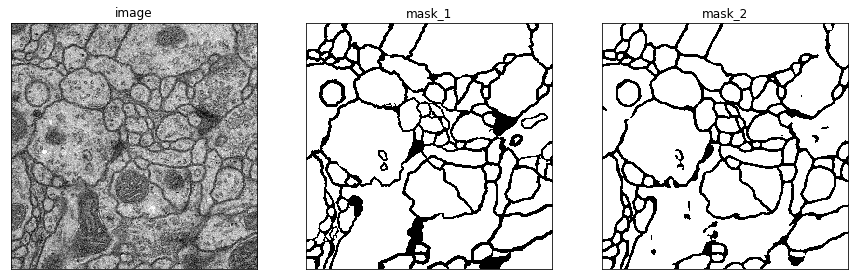

In [7]:
plot_masks(img_arr, [mask_arr, mask_pred])

In [10]:
f1_score(mask_arr.reshape(-1), mask_pred.reshape(-1), pos_label=0)

0.8134227368463894

## 2 - model with custom loss

Here're main changes in this model: 

- we changed metric to `dice_coef` (that's `f1` score in case of binary tensors); this is popular choice for segmentation (we have much more white color than the black one); we have to compute it properly - first flip an then compute dot product;
- we changed loss function to the sum of `binary crossentropy` and `dice loss` - popular function for segmentation tasks;
- we expanded the validation set;
- we added `EarlyStopping` callback;

But we don't see any significant increase in accuracy. So we don't even submit results.

In [13]:
experiment_dir=Path('experiments/custom_metric')
trainer = Trainer(experiment_dir=experiment_dir)

In [14]:
trainer.params.dict

{'learning_rate': 0.001,
 'input_shape': [512, 512, 1],
 'steps_per_epoch': 100,
 'epochs': 40,
 'batch_size': 4,
 'start_epoch': 0,
 'last_step': 10,
 'padding': 'same',
 'batch_size_val': 1,
 'validation_steps': 3,
 'batch_size_test': 1}

In [16]:
!ls experiments/custom_metric/

copy.sh
events.out.tfevents.1572281543.instance-2-gpu
params.json
weights.07-0.42.hdf5


In [17]:
# image 25 was on validation set for this model
img_arr = trainer.dataset.image_data[25]
mask_arr = trainer.dataset.mask_data[25] / 255.

In [19]:
weight_file = str(experiment_dir / 'weights.07-0.42.hdf5')
mask_pred = trainer.predict_image(img_arr, weight_file)

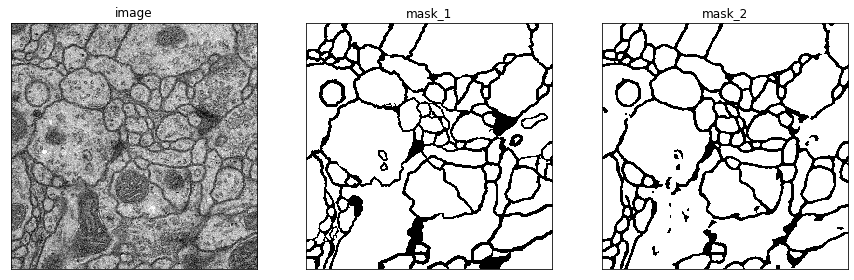

In [20]:
plot_masks(img_arr, [mask_arr, mask_pred])

In [21]:
f1_score(mask_arr.reshape(-1), mask_pred.reshape(-1), pos_label=0)

0.8119151774329602

## 3 - updated model

We use the model from this [repository](https://github.com/alexklibisz/isbi-2012). Here're some differences:

- we added `Dropout(.2)` in contracting pass;
- we added `he_normal` kernel initialization;
- we used `init_filters: 64` as in the previous model (and as in the original Unet); 

Looks like this won't help a lot. We have even lower `f1` score.

In [4]:
experiment_dir=Path('experiments/updated_unet')
trainer = Trainer(experiment_dir=experiment_dir)

In [5]:
trainer.params.dict

{'learning_rate': 0.001,
 'steps_per_epoch': 10,
 'epochs': 1,
 'batch_size': 4,
 'start_epoch': 0,
 'last_step': 10,
 'batch_size_val': 1,
 'validation_steps': 3,
 'batch_size_test': 1,
 'input_shape': [512, 512, 1],
 'kernel_initializer': 'he_normal',
 'init_filters': 64,
 'dropout': 0.2}

In [6]:
!ls experiments/updated_unet/

copy.sh
events.out.tfevents.1572361217.instance-2-gpu
params.json
weights.11-0.35.hdf5


In [7]:
# image 25 was on validation set for this model
img_arr = trainer.dataset.image_data[25]
mask_arr = trainer.dataset.mask_data[25] / 255.

In [8]:
weight_file = str(experiment_dir / 'weights.11-0.35.hdf5')
mask_pred = trainer.predict_image(img_arr, weight_file)

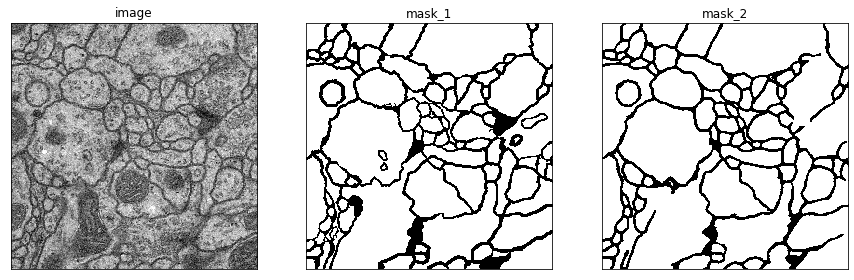

In [9]:
plot_masks(img_arr, [mask_arr, mask_pred])

In [10]:
f1_score(mask_arr.reshape(-1), mask_pred.reshape(-1), pos_label=0)

0.8057791117668005

## 4 - choosing learning rate

We choose from `learning_rates = [.001, .0005, .0001, .00005]`. Rates `[.1, .01, .005]` are too high (we get extremely big losses). The last 2 rates are too low - training seems to go very slowly (we don't even include the last one in plots). And `.0005` seems a little bit better. 

In [2]:
dir_path = Path('experiments/learning_rates/')

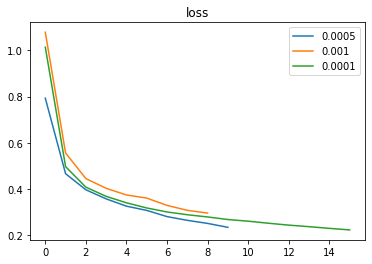

In [3]:
plot_metric_lr('loss', dir_path)

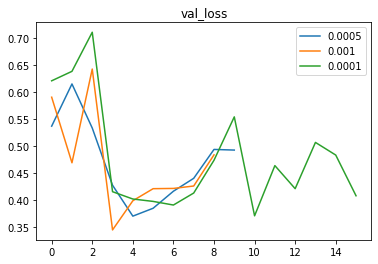

In [4]:
plot_metric_lr('val_loss', dir_path)

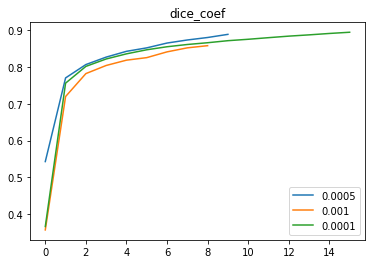

In [5]:
plot_metric_lr('dice_coef', dir_path)

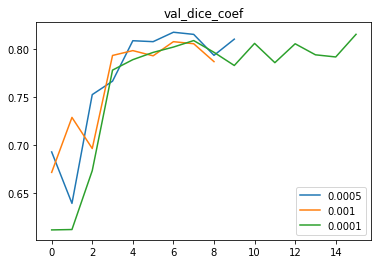

In [6]:
plot_metric_lr('val_dice_coef', dir_path)

Let's now add learning schedule and retrain.

## 5 - tuning learning rate

We changed `lr` to `.0005` based on results above and added `ReduceLROnPlateau` callbacks.

In [2]:
experiment_dir=Path('experiments/lr_tuning')
trainer = Trainer(experiment_dir=experiment_dir)

In [3]:
trainer.params.dict

{'learning_rate': 0.0005,
 'steps_per_epoch': 100,
 'epochs': 50,
 'batch_size': 4,
 'start_epoch': 0,
 'last_step': 10,
 'batch_size_val': 1,
 'validation_steps': 3,
 'batch_size_test': 1,
 'input_shape': [512, 512, 1],
 'kernel_initializer': 'he_normal',
 'init_filters': 64,
 'dropout': 0.2}

In [4]:
!ls experiments/lr_tuning/

copy.sh
events.out.tfevents.1572425249.instance-2-gpu
history.pickle
params.json
weights_loss.hdf5
weights_val_loss.hdf5


In [5]:
# image 25 was on validation set for this model
img_arr = trainer.dataset.image_data[25]
mask_arr = trainer.dataset.mask_data[25] / 255.

In [6]:
weight_file = str(experiment_dir / 'weights_val_loss.hdf5')
mask_pred = trainer.predict_image(img_arr, weight_file)

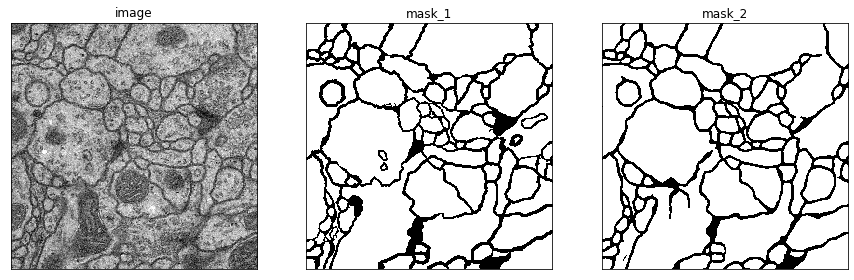

In [7]:
plot_masks(img_arr, [mask_arr, mask_pred])

In [8]:
f1_score(mask_arr.reshape(-1), mask_pred.reshape(-1), pos_label=0)

0.8128353031342019

In [9]:
weight_file = str(experiment_dir / 'weights_loss.hdf5')
mask_pred = trainer.predict_image(img_arr, weight_file)

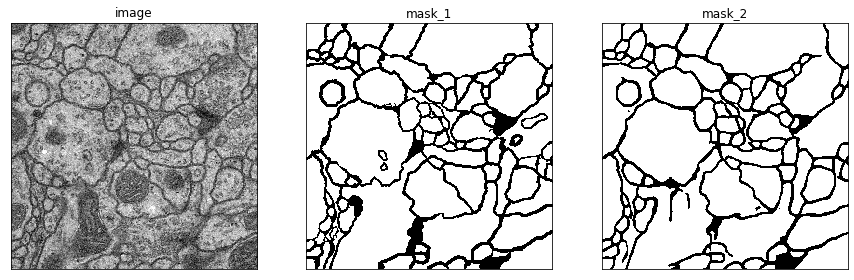

In [10]:
plot_masks(img_arr, [mask_arr, mask_pred])

In [11]:
f1_score(mask_arr.reshape(-1), mask_pred.reshape(-1), pos_label=0)

0.8059842741651313

## 6 - tuning dropout

If we look at the results of training we can see that training results are improving but we just can't improve validation results. So let's try to tune dropout. We choose `dropout_rates = [.2, .3, .4, .5]`. So we may see that dropout maybe help but not very much.

In [2]:
dir_path = Path('experiments/dropout/')

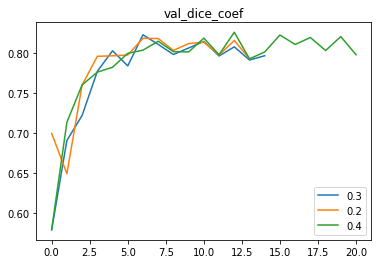

In [6]:
plot_metric('val_dice_coef', dir_path)

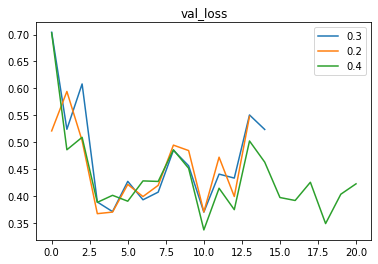

In [7]:
plot_metric('val_loss', dir_path)

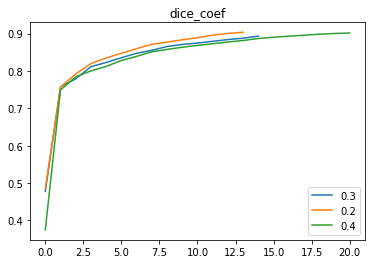

In [9]:
plot_metric('dice_coef', dir_path)

## 7 - klibisz model

Let's now run klibisz model and look at its metrics. Looks like results are much better. For example `val_dice_coef` is in the range .87-.9 while in my model it's in the range ~.8. And its steadily improving. My best guess that issue is with data augmentation.

In [1]:
filename = 'example_alexklibisz/checkpoints/unet_64/history.pickle'

In [3]:
history = load_history(filename)

In [4]:
history.keys()

dict_keys(['val_loss', 'val_dice_coef', 'loss', 'dice_coef', 'lr'])

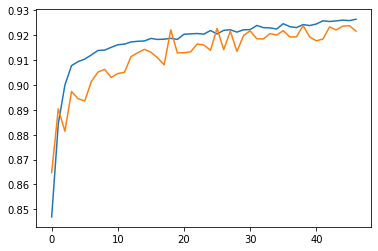

In [11]:
plt.plot(history['dice_coef']);
plt.plot(history['val_dice_coef']);

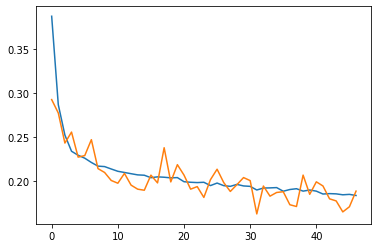

In [10]:
plt.plot(history['loss']);
plt.plot(history['val_loss']);